In [1]:
import pandas as pd
import matplotlib.pyplot as plt
base_Edu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_Edu.parquet")
base_Edu

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,3838161406066513919,41,0,2017-12-17 15:00:23.000000,265,0,3,0,3,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
1,5829430568065349352,0,0,2022-07-07 12:02:53.000000,27,0,0,0,11,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
2,7677180318050051984,787,788,2022-05-10 01:35:49.000000,295,0,0,0,73,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
3,-5150597998144597550,615,616,2024-04-18 04:56:03.262330,138,0,0,0,75,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
4,969323468959211246,169,170,2019-03-19 12:32:56.000000,554,0,0,0,41,120,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1306435320134834461,0,-4,2021-02-25 10:11:13.000000,7,0,0,0,11,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
199996,5732789662758255879,0,0,2017-12-06 15:46:14.000000,45,0,0,0,7,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199997,3325713948509922176,17,9,2019-07-21 18:24:08.000000,229,0,0,0,83,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199998,7446387329160512320,68,57,2021-10-28 19:09:58.000000,172,0,242,0,310,120,...,0,0,0,15,0,0,0.0,100.0,0.0,0.0


In [2]:
print(base_Edu.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 477 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(254), datetime64[us](1), float64(150)
memory usage: 450.9 MB
None


La base de données compte donc 477 variables dont 72 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 221 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [3]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.743390
std        0.279055
min        0.047720
25%        0.666710
50%        0.842345
75%        0.918625
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [4]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [5]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.903116
std        0.072136
min        0.695085
25%        0.837765
50%        0.883305
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comporte pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [6]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [7]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.475770
std        0.292138
min        0.047720
25%        0.184915
50%        0.483995
75%        0.736010
max        0.941710
dtype: float64

Pour les variables quantitatives, la distribution des valeurs manquantes est plus étendue. On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum de 4% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables avant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [8]:
miss_quant[miss_quant<=0.20].describe()

count    118.000000
mean       0.054362
std        0.074368
min        0.000000
25%        0.000000
50%        0.000000
75%        0.106310
max        0.194530
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (118 sont conservées sur un total de 151)

In [9]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [10]:
base_Edu.isnull().any().sum()

0

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

## ACP

In [11]:
#base_acp=base_Edu.select_dtypes(include=["int","float"]).drop(columns="unique_learner_id")

In [12]:
#pip install ploty

In [13]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
 
# # Étape 1 : Identifier les colonnes catégorielles
# #base_acp=base_Edu.select_dtypes('float').drop(columns="unique_learner_id")
# categorical_columns = base_acp.select_dtypes(include=['object', 'category']).columns
# numerical_columns = base_acp.select_dtypes(include=['int64', 'float64']).columns

# # Étape 2 : Encodage One-Hot des colonnes catégorielles
# encoder = OneHotEncoder(sparse_output=False)
# encoded_categorical = encoder.fit_transform(base_acp[categorical_columns])
# modalities = encoder.get_feature_names_out(categorical_columns)  # Noms des modalités encodées

# # Étape 3 : Combiner les colonnes numériques et encodées
# import numpy as np
# if numerical_columns.any():
#     combined_data = np.hstack((base_acp[numerical_columns].values, encoded_categorical))
# else:
#     combined_data = encoded_categorical

# #Centrer et réduire les variables 
# scaler=StandardScaler()
# base_acp=scaler.fit_transform(base_acp)

# # Étape 4 : Application de l'ACP
# pca = PCA(n_components=10)
# components = pca.fit_transform(combined_data)
 
# # Créer un DataFrame avec les trois premiers axes
# pca_df = pd.DataFrame(
#     components,
#     columns=['PCA1', 'PCA2', 'PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10']
# )

# # Étape 5 : Visualisation des composantes principales
# plt.figure(figsize=(8, 6))
# plt.scatter(components[:, 0], components[:, 1], s=100, alpha=0.7, c='blue')
# plt.title('Analyse en composantes principale (ACP)')
# plt.xlabel('Composante principale 1')
# plt.ylabel('Composante principale 2')
# plt.grid()
# plt.show()

# # Étape 6 : Variance expliquée par chaque composante
# print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)

In [14]:
# # Étape 3 : Récupérer la variance expliquée
# explained_variance = pca.explained_variance_ratio_

# # Afficher la variance expliquée par axe
# for i, var in enumerate(explained_variance, start=1):
#     print(f"Axe {i}: {var * 100:.2f}% de variance expliquée")


# import matplotlib.pyplot as plt

# # Graphique de la variance expliquée
# plt.figure(figsize=(8, 5))
# plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='blue', alpha=0.7)
# plt.title('Variance expliquée par axe')
# plt.xlabel('Axe')
# plt.ylabel('Variance expliquée (%)')
# plt.xticks(range(1, len(explained_variance) + 1))
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

## FAMD

In [15]:
#!pip install prince

In [16]:
# base_Edu.info()
# base_Edu_sample = base_Edu.sample(n=5000, random_state=42)

In [17]:
# import pandas as pd
# from prince import FAMD


# # Identifier les types de colonnes
# numeric_cols = base_Edu_sample.select_dtypes(include=['int64', 'float64']).columns
# categorical_cols = base_Edu_sample.select_dtypes(include=['category', 'object', 'bool']).columns

# # Note : Les colonnes datetime64 ne sont pas directement utilisables dans la FAMD.
# # On pourrait les transformer si elles ont du sens (par exemple en extraire l'année, le mois, etc.)
# datetime_cols = base_Edu_sample.select_dtypes(include=['datetime64']).columns
# #une tab
# if len(datetime_cols) > 0:
#     print("Transformation des colonnes datetime")
#     for col in datetime_cols:
#         base_Edu_sample[col + '_year'] = base_Edu_sample[col].dt.year
#         base_Edu_sample[col + '_month'] = base_Edu_sample[col].dt.month
#         base_Edu_sample[col + '_day'] = base_Edu_sample[col].dt.day
#     base_Edu_sample = base_Edu_sample.drop(columns=datetime_cols)

# # Application de la FAMD
# famd = FAMD(n_components=378, random_state=42)  # Conserver 10 dimensions
# print("je suis là")
# base_Edu_reduced = famd.fit_transform(base_Edu_sample)
# print('jai fini')
# # Résultat : DataFrame réduit
# base_Edu_reduced = pd.DataFrame(base_Edu_reduced, columns=[f"FAMD_{i+1}" for i in range(base_Edu_reduced.shape[1])])

# # Afficher les premières lignes
# print(base_Edu_reduced.head())

## Auto-Encoder

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base q qui ne présentent aucun intérêt pour notre auto encoder

Pour des raisons liées à la puissance de calcul, nous nous servirons de la moité des observations pour notre Auto-Encoder. 

In [18]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(100000)

Les résultats obtenus avec un Auto-Encoder dépendent de la valeur de la dimension de l'espace latent choisi c'est à dire le nombre de variables de sorties. Dans un premier temps, nous réaliserons donc l'Auto-Encoder pour plusieurs valeurs de l'hyperparamètre ( ici 3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39 et 41 ) et au vu des résultats déciderons d'une valeur optimale du paramètre 

    encoding_dim      loss
0              1  0.064415
1              2  0.038348
2              3  0.036574
3              4  0.035920
4              5  0.034519
5              6  0.031529
6              7  0.031794
7              8  0.031891
8              9  0.029545
9             10  0.027860
10            11  0.025605
11            12  0.027422
12            13  0.027384
13            14  0.025558
14            15  0.026702
15            16  0.026336
16            17  0.023099
17            18  0.023201
18            19  0.024823
19            20  0.020567


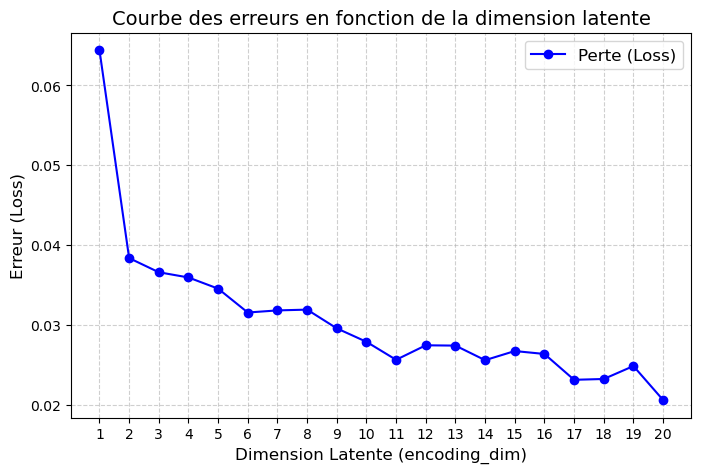

In [19]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt

# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=42)

# Dimensions de l'entrée et du codage
input_dim = x_train.shape[1]  # Nombre de caractéristiques

#encoding_dimension = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41]
# Liste pour suivre les résultats (dimension latente et perte associée)
results = []

# Essai de différentes dimensions latentes
for encoding_dim in range(1,21):  # Tester des dimensions latentes de 1 à 20
    # Construction de l'auto-encodeur
    input_img = Input(shape=(input_dim,))
    
    # Encodeur
    Hidden = Dense(encoding_dim, activation='relu')(input_img)
    encoded = Dense(encoding_dim, activation='relu')(Hidden)
    
    # Décodeur
    Hidden_output = Dense(input_dim, activation='sigmoid')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(Hidden_output)
    
    # Créer le modèle
    autoencoder = Model(input_img, decoded)
    
    # Compiler le modèle
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Entraîner le modèle
    history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)
    
    # Récupérer la perte de validation à la dernière époque
    final_loss = history.history['val_loss'][-1]
    
    # Ajouter la dimension et la perte au tableau des résultats
    results.append({'encoding_dim': encoding_dim, 'loss': final_loss})

# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Tracé de la courbe
plt.figure(figsize=(8, 5))
plt.plot(df_results['encoding_dim'], df_results['loss'], marker='o', linestyle='-', color='b', label='Perte (Loss)')

# Marquer les axes et le titre
plt.xlabel('Dimension Latente (encoding_dim)', fontsize=12)
plt.ylabel('Erreur (Loss)', fontsize=12)
plt.title('Courbe des erreurs en fonction de la dimension latente', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_results['encoding_dim'])
plt.legend(fontsize=12)

# Afficher la courbe
plt.show()



#Autre méthode
# encoding_dim = 10  # Dimension de l'espace latent (tu peux ajuster ce nombre)

# # Construction de l'Auto-Encoder
# # 1. Définir l'entrée du modèle
# input_img = Input(shape=(input_dim,))

# # 2. Encoder
# encoded = Dense(encoding_dim, activation='relu')(input_img)

# # 3. Décoder
# decoded = Dense(input_dim, activation='sigmoid')(encoded)

# # 4. Créer l'auto-encodeur
# autoencoder = Model(input_img, decoded)

# # Compiler le modèle
# autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

# # Entraînement du modèle
# autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# # 5. Extraire l'encodeur uniquement
# encoder = Model(input_img, encoded)

# # Visualisation des résultats
# encoded_imgs = encoder.predict(x_test)  # Représentation encodée
# decoded_imgs = autoencoder.predict(x_test)  # Données reconstruites

# # Visualisation des images originales et reconstruites
# n = 2  # Nombre d'images à afficher
# plt.figure(figsize=(20, 4))

# for i in range(n):
#     # Données originales
#     ax = plt.subplot(2, n, i + 1)
#     plt.bar(range(len(x_test[i])), x_test[i])  # Affichage sous forme de barres
#     plt.title(f"Original {i+1}")
#     plt.axis('off')  # Cacher les axes

#     # Reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
#     plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])  # Affichage sous forme de barres
#     plt.title(f"Reconstructed {i+1}")
#     plt.axis('off')  # Cacher les axes

# plt.show()


Le graphque précédent représente la courbe des erreurs en fonctions des diverses valeurs de l'hyperparamètre k initialement choisis. L’analyse de cette courbe montre une diminution rapide de la perte jusqu’à cette valeur, indiquant que k=25 capture efficacement la structure principale des données. Au-delà de k=11, la réduction des erreurs devient très faible, suggérant que l’ajout de dimensions supplémentaires n’apporte qu’un faible gain en reconstruction tout en augmentant la complexité du modèle. Nous retenons donc ici comme valeur de l'hyperparamètre k (dimension de l'espace latent) la valeur 11. Cette valeur offre aussi un compromis entre interprétation raisonnable des variables latentes et reconstruction efficace des données. 

Epoch 1/50
274/274 [==============================] - 6s 18ms/step - loss: 0.0467 - val_loss: 0.0395
Epoch 2/50
274/274 [==============================] - 5s 17ms/step - loss: 0.0379 - val_loss: 0.0371
Epoch 3/50
274/274 [==============================] - 5s 17ms/step - loss: 0.0363 - val_loss: 0.0362
Epoch 4/50
274/274 [==============================] - 5s 17ms/step - loss: 0.0357 - val_loss: 0.0358
Epoch 5/50
274/274 [==============================] - 5s 17ms/step - loss: 0.0353 - val_loss: 0.0353
Epoch 6/50
274/274 [==============================] - 5s 17ms/step - loss: 0.0349 - val_loss: 0.0349
Epoch 7/50
274/274 [==============================] - 5s 17ms/step - loss: 0.0345 - val_loss: 0.0345
Epoch 8/50
274/274 [==============================] - 5s 17ms/step - loss: 0.0340 - val_loss: 0.0340
Epoch 9/50
274/274 [==============================] - 5s 19ms/step - loss: 0.0336 - val_loss: 0.0337
Epoch 10/50
274/274 [==============================] - 5s 18ms/step - loss: 0.0333 - val_lo

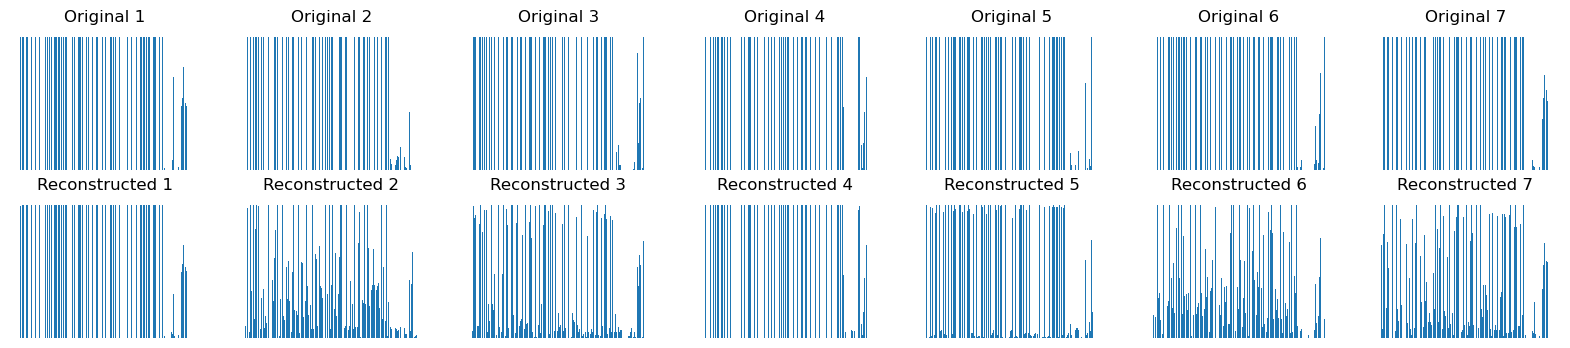

Erreur moyenne de reconstruction : 0.0272


In [29]:
# Fixer la dimension latente optimale
encoding_dim = 11

# Construction de l'auto-encodeur
input_img = Input(shape=(input_dim,))

# Encodeur
Hidden = Dense(encoding_dim, activation='relu',name="Hidden_name")(input_img)
encoded = Dense(encoding_dim, activation='relu',name="encoder_name")(Hidden)

# Décodeur
Hidden_output = Dense(input_dim, activation='sigmoid')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(Hidden_output)

# Création du modèle auto-encodeur
autoencoder = Model(input_img, decoded)

# Compiler le modèle
autoencoder.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
history = autoencoder.fit(x_train, x_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True, 
                          validation_data=(x_test, x_test), 
                          verbose=1)

# Extraire uniquement l'encodeur pour obtenir la représentation dans l'espace latent
encoder = Model(input_img, encoded)

# Obtenir les représentations encodées (dans l'espace latent)
encoded_imgs = encoder.predict(x_test)

# Reconstruire les images (après passage par l'auto-encodeur)
decoded_imgs = autoencoder.predict(x_test)

# Visualisation des performances
n = 7  # Nombre de cas à visualiser
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


Le graphque précédent fait une comparaison entre les 7 premières données originales et leurs versions reconstruites (pour une dimension k=25 de l'espace latent). Et la ressemblence obervée est très forte. Cela témoigne du fait que la valeur k=25 de l'hyperparamètre suffit à capturer efficacement la structire initiale de nos données. 

In [33]:
# Extraire l'encodeur
encoder = Model(autoencoder.input, autoencoder.get_layer("encoder_name").output)

# Transformer les données d'entrée en espace latent
latent_variables = encoder.predict(final_data)

# Vérifier les dimensions des nouvelles variables
print("Forme des nouvelles variables :", latent_variables.shape)

# Créer un DataFrame à partir des nouvelles variables
latent_df = pd.DataFrame(latent_variables, columns=[f"Latent_Var_{i+1}" for i in range(latent_variables.shape[1])])

print("\n Reprsésentation des premières observations dans la dimension latente : ")

# Afficher un aperçu
print(latent_df.head(4))

3125/3125 [==============================] - 7s 2ms/step
Forme des nouvelles variables : (100000, 11)

 Reprsésentation des premières observations dans la dimension latente : 
   Latent_Var_1  Latent_Var_2  Latent_Var_3  Latent_Var_4  Latent_Var_5  \
0     44.270458     14.467652      7.688179     51.918541     27.463518   
1     43.996872     14.842267      8.183390     52.204773     27.774748   
2     26.265779     21.455900     11.638580     67.655380     24.070023   
3     60.009087     68.344658     40.000858     30.848164      7.544008   

   Latent_Var_6  Latent_Var_7  Latent_Var_8  Latent_Var_9  Latent_Var_10  \
0     16.849503           0.0     24.836243     12.001082       9.284972   
1     17.513273           0.0     23.802338     11.994738       9.212626   
2     25.867216           0.0     29.248625     19.986397       9.653869   
3     50.026989           0.0     24.588034     22.938484       0.000000   

   Latent_Var_11  
0            0.0  
1            0.0  
2         

In [34]:
# Variance de chaque variable latente
latent_variances = np.var(latent_variables, axis=0)

# Contribution proportionnelle de chaque variable latente
latent_contributions = latent_variances / np.sum(latent_variances)

# Affichage des contributions
for i, contrib in enumerate(latent_contributions):
    print(f"Contribution de la Latent_Var_{i+1}: {contrib:.2%}")

Contribution de la Latent_Var_1: 6.25%
Contribution de la Latent_Var_2: 11.31%
Contribution de la Latent_Var_3: 53.12%
Contribution de la Latent_Var_4: 10.29%
Contribution de la Latent_Var_5: 2.08%
Contribution de la Latent_Var_6: 6.85%
Contribution de la Latent_Var_7: 0.00%
Contribution de la Latent_Var_8: 2.64%
Contribution de la Latent_Var_9: 6.19%
Contribution de la Latent_Var_10: 1.27%
Contribution de la Latent_Var_11: 0.00%


La sortie précédente montre la contribution des diverses variables latentes c'est à dire la part d'information que chacune d'elles comportent. 

In [31]:
# Récupération des poids des couches
W1, b1 = autoencoder.get_layer("Hidden_name").get_weights()  # Entrée → Couche cachée
W2, b2 = autoencoder.get_layer("encoder_name").get_weights()  # Couche cachée → Espace latent

# Calcul des poids effectifs (influence des entrées sur l'espace latent)
W_eff = np.dot(W1, W2)  # Multiplication matricielle
num_top_variables = 10  # Nombre de variables les plus influentes à afficher

for i in range(encoding_dim):  # Parcours des dimensions latentes
    print(f"\nDimension latente {i+1}:")
    column_weights = np.abs(W_eff[:, i])  # Importance absolue des poids
    top_indices = np.argsort(column_weights)[-num_top_variables:][::-1]  # Top indices
    top_variables = [final_columns[idx] for idx in top_indices]  # Noms des variables influentes
    print(f"Variables influentes : {top_variables}")
    print(f"Poids correspondants : {column_weights[top_indices]}")


Dimension latente 1:
Variables influentes : ['prendre_quitter_vehicule_number_of_activities', 'premiers_secours_number_of_activities', 'notions_diverses_number_of_activities', 'securite_number_of_activities', 'choice_00_d793123e-7c12-47de-8352-5eeefc6b088e_0', 'choice_01_d793123e-7c12-47de-8352-5eeefc6b088e_0', 'choice_03_f581c15d-eca9-4b40-88e5-37887323a4a9_1', 'is_correct_f581c15d-eca9-4b40-88e5-37887323a4a9_1', 'choice_02_d793123e-7c12-47de-8352-5eeefc6b088e_0', 'mecanique_equipements_number_of_activities']
Poids correspondants : [8.106217  4.31063   4.2853665 3.948759  3.2692459 2.7901592 2.6900208
 2.5433514 2.4724636 2.3085482]

Dimension latente 2:
Variables influentes : ['choice_03_f581c15d-eca9-4b40-88e5-37887323a4a9_1', 'is_correct_f581c15d-eca9-4b40-88e5-37887323a4a9_1', 'choice_02_f581c15d-eca9-4b40-88e5-37887323a4a9_1', 'choice_01_f581c15d-eca9-4b40-88e5-37887323a4a9_1', 'choice_00_f581c15d-eca9-4b40-88e5-37887323a4a9_1', 'prendre_quitter_vehicule_number_of_activities', '

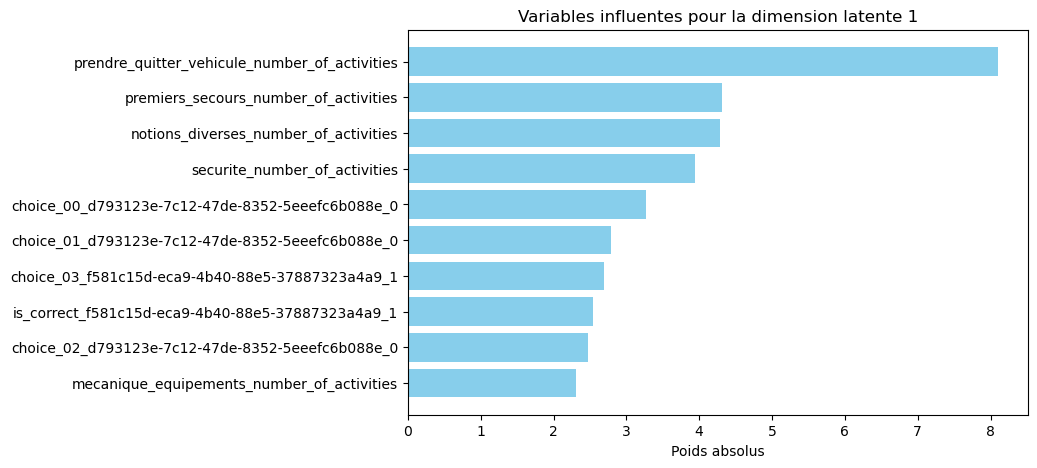

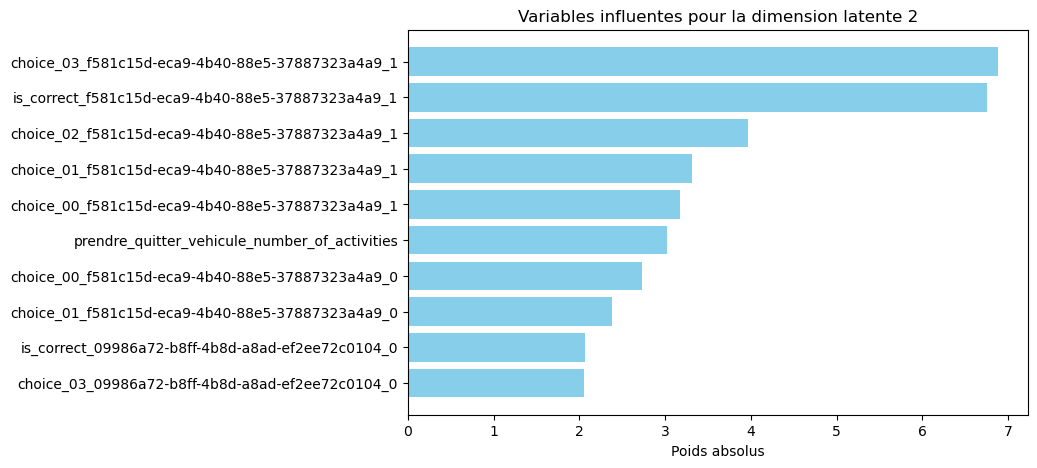

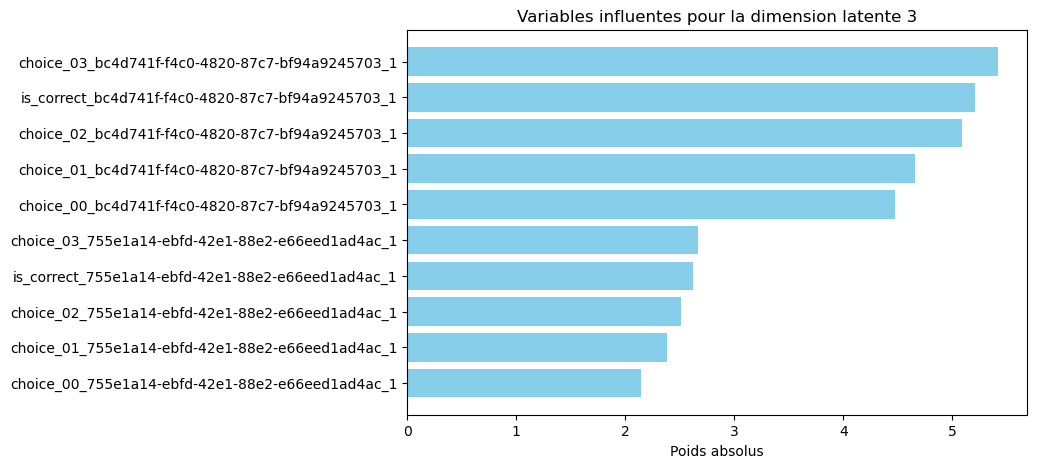

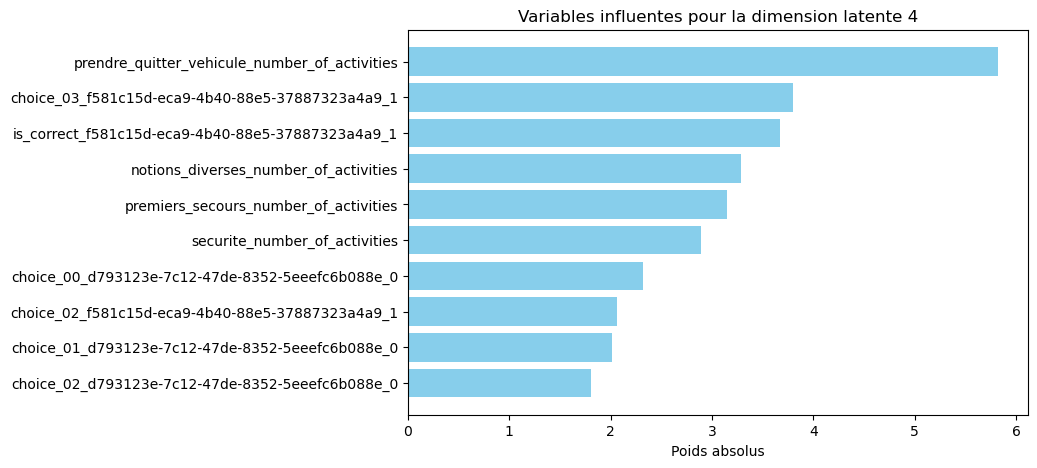

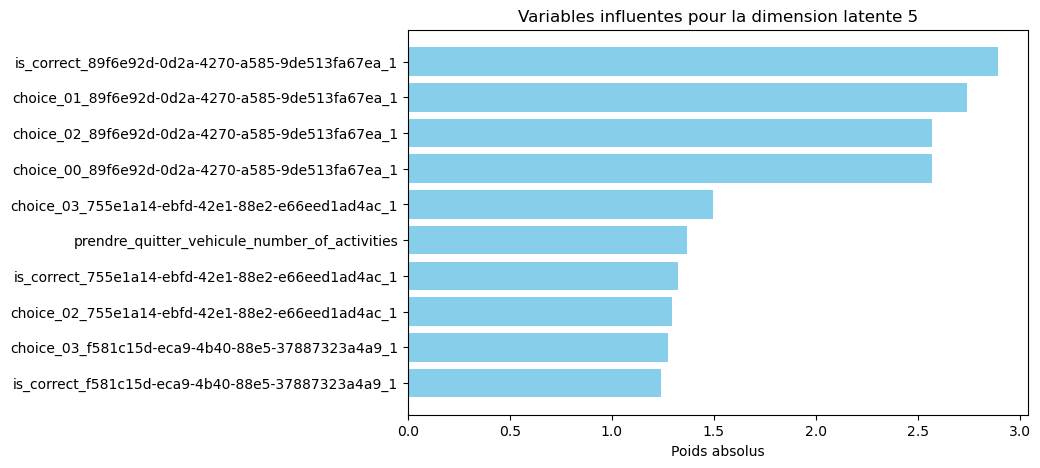

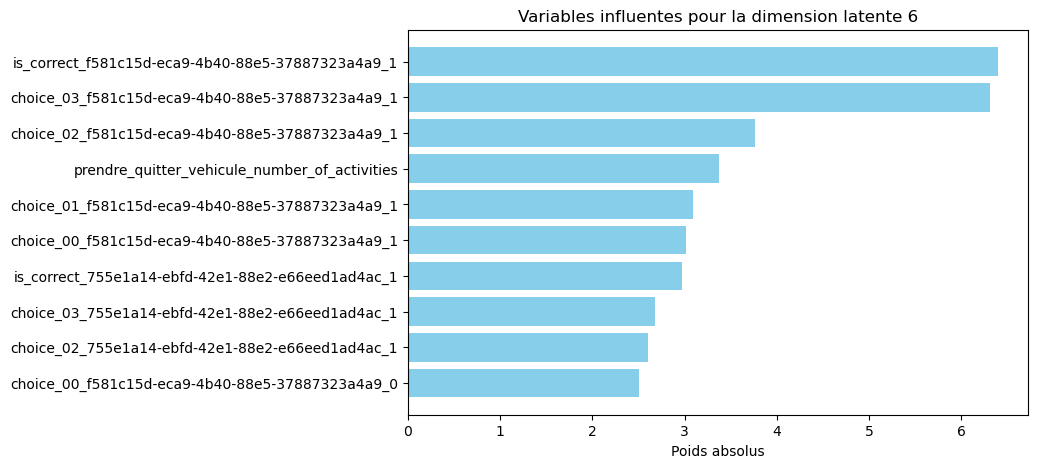

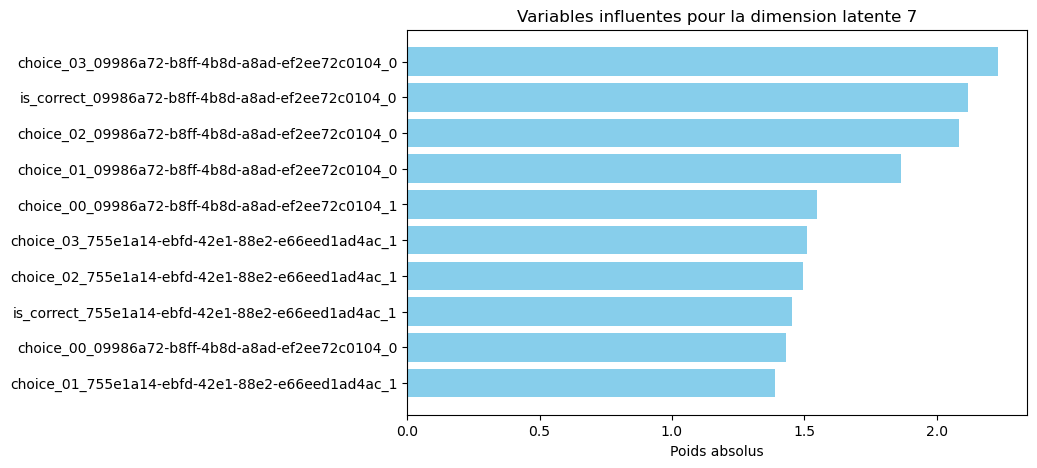

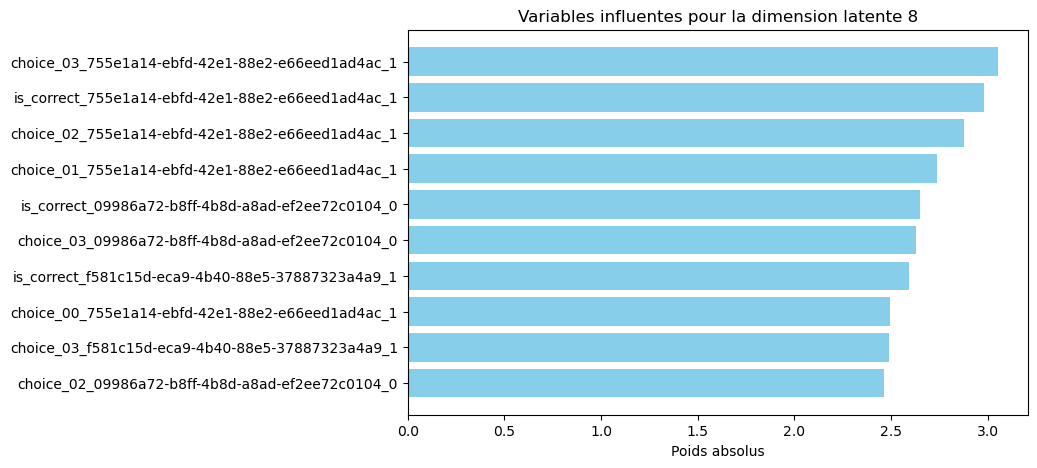

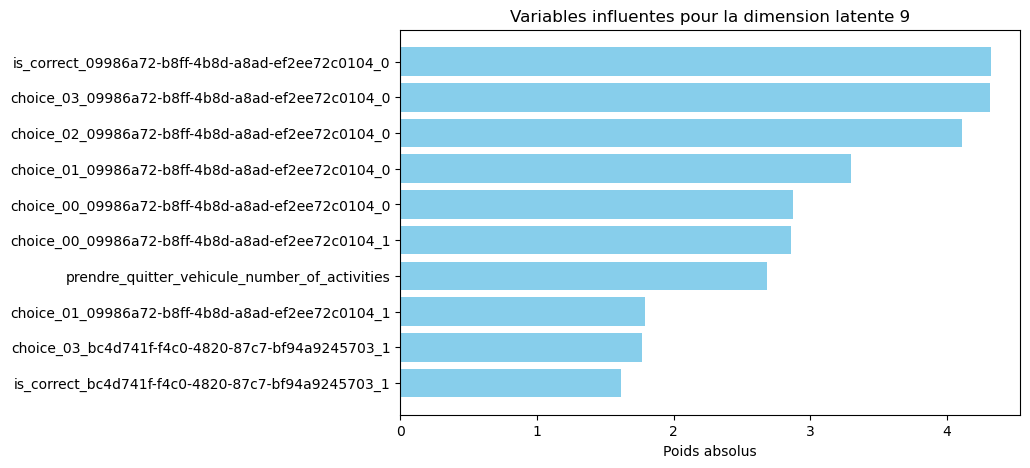

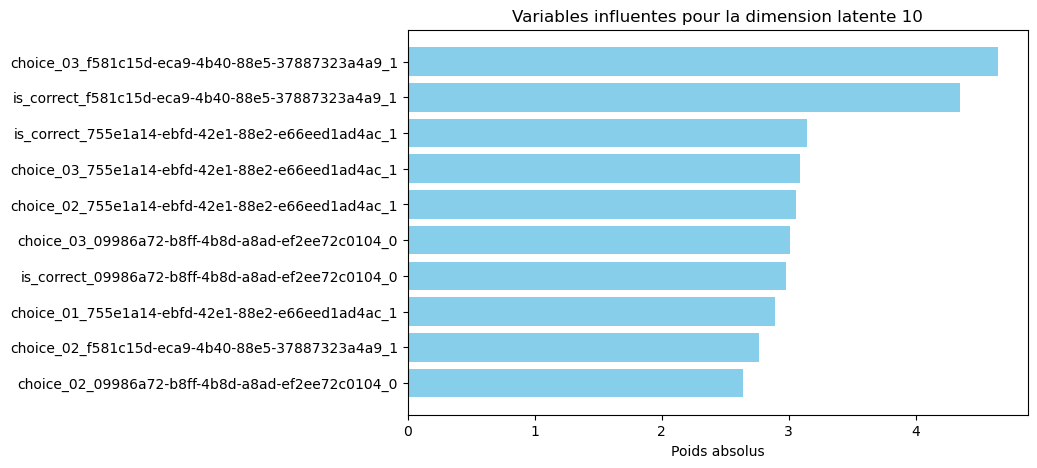

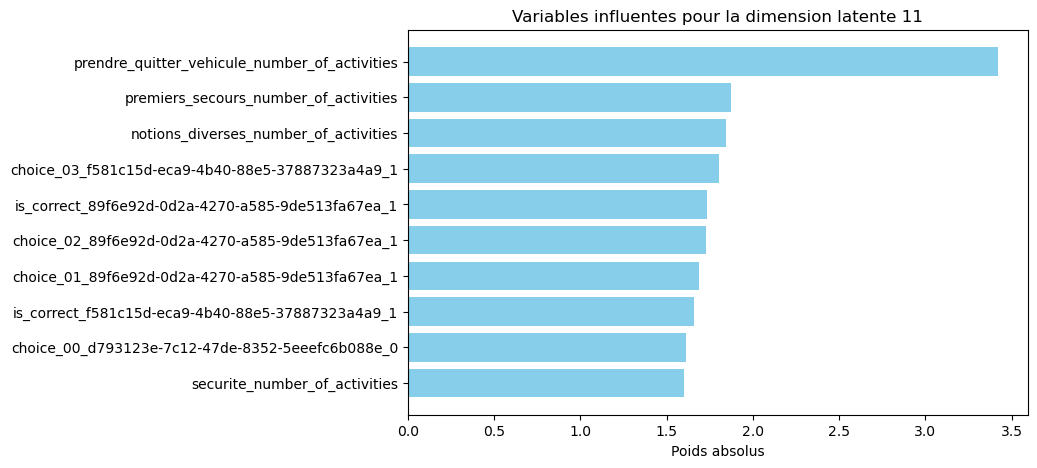

In [32]:
for i in range(encoding_dim):
    column_weights = np.abs(W_eff[:, i])  # Utilisation des poids effectifs
    top_indices = np.argsort(column_weights)[-num_top_variables:][::-1]  # Top indices
    top_variables = [final_columns[idx] for idx in top_indices]  # Noms des variables influentes
    top_weights = column_weights[top_indices]  # Valeurs des poids

    # Affichage du graphique
    plt.figure(figsize=(8, 5))
    plt.barh(top_variables, top_weights, color='skyblue')
    plt.xlabel('Poids absolus')
    plt.title(f'Variables influentes pour la dimension latente {i+1}')
    plt.gca().invert_yaxis()  # Inversion de l’axe Y pour un affichage ordonné
    plt.show()
